<a href="https://colab.research.google.com/github/darshita27-cmd/LDA-or-K-means-on-a-large-text-corpora/blob/main/mymodel_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# libraries needed


import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
from gensim import corpora, models
from gensim.models import CoherenceModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import string
import re
from collections import Counter
import matplotlib.pyplot as plt
import os
from wordcloud import WordCloud

In [16]:
# downloading the NLTK data

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [17]:

# loading and processing the data
def load_data():
    newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
    return newsgroups.data, newsgroups.target, newsgroups.target_names


def preprocess_text(documents):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    def clean_text(text):
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(text)
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 3]
        return tokens

    tokenized_docs = [clean_text(doc) for doc in documents]
    word_counts = Counter(word for doc in tokenized_docs for word in doc)
    tokenized_docs = [[word for word in doc if word_counts[word] > 5] for doc in tokenized_docs]
    return tokenized_docs


In [18]:
# Kmeans

def kmeans_clustering(documents, n_clusters=15):
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X = vectorizer.fit_transform(documents)
    svd = TruncatedSVD(n_components=100, random_state=42)
    X_reduced = svd.fit_transform(X)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_reduced)
    score = silhouette_score(X_reduced, clusters)
    print(f"K-means Silhouette Score: {score:.4f}")
    svd_2d = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd_2d.fit_transform(X)
    return clusters, X_2d, vectorizer.get_feature_names_out()


In [19]:

# LDA
def lda_topic_modeling(tokenized_docs, n_topics=15):
    dictionary = corpora.Dictionary(tokenized_docs)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]
    lda_model = models.LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=15, random_state=42)
    doc_topics = [lda_model[doc] for doc in corpus]
    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"LDA Coherence Score: {coherence_score:.4f}")
    return lda_model, dictionary, corpus, doc_topics


In [20]:
# visualization

# for Kmeans
def visualize_clusters(X_2d, clusters, targets, target_names):
    print("Generating K-means cluster visualization...")
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=clusters, cmap='viridis', alpha=0.5, s=50)
    plt.colorbar(scatter, label='Cluster ID')
    plt.title("K-means Clustering of 20 Newsgroups (2D SVD Projection)", fontsize=14, pad=15)
    plt.xlabel("SVD Component 1", fontsize=12)
    plt.ylabel("SVD Component 2", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Annotate a few sample points with category names
    for cluster in range(max(clusters) + 1):
        cluster_indices = [i for i, c in enumerate(clusters) if c == cluster]
        if cluster_indices:
            sample_idx = cluster_indices[0]
            if sample_idx < len(targets):
                category = target_names[targets[sample_idx]]
                plt.annotate(
                    category.split('.')[-1][:10],
                    (X_2d[sample_idx, 0], X_2d[sample_idx, 1]),
                    textcoords="offset points",
                    xytext=(0, 10),
                    ha='center',
                    fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8)
                )

    plt.tight_layout()
    output_path = os.path.abspath("kmeans_clusters_annotated.png")
    plt.savefig(output_path, dpi=300)
    print(f"K-means plot saved to: {output_path}")
    plt.show()
    plt.close()


# wordcloud for LDA


def visualize_lda_topics(lda_model, n_top_words=10):
    print("Generating LDA topic word clouds...")
    for topic_idx, topic in lda_model.show_topics(num_topics=-1, num_words=n_top_words, formatted=False):
        word_weights = {word: weight for word, weight in topic}
        wordcloud = WordCloud(width=800, height=400,background_color='white',min_font_size=10,max_font_size=150,random_state=42).generate_from_frequencies(word_weights)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"LDA Topic {topic_idx}", fontsize=14, pad=10)
        output_path = os.path.abspath(f"lda_topic_{topic_idx}.png")
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"LDA topic {topic_idx} word cloud saved to: {output_path}")
        plt.show()
        plt.close()

K-means Silhouette Score: 0.0529
Generating K-means cluster visualization...
K-means plot saved to: /content/kmeans_clusters_annotated.png


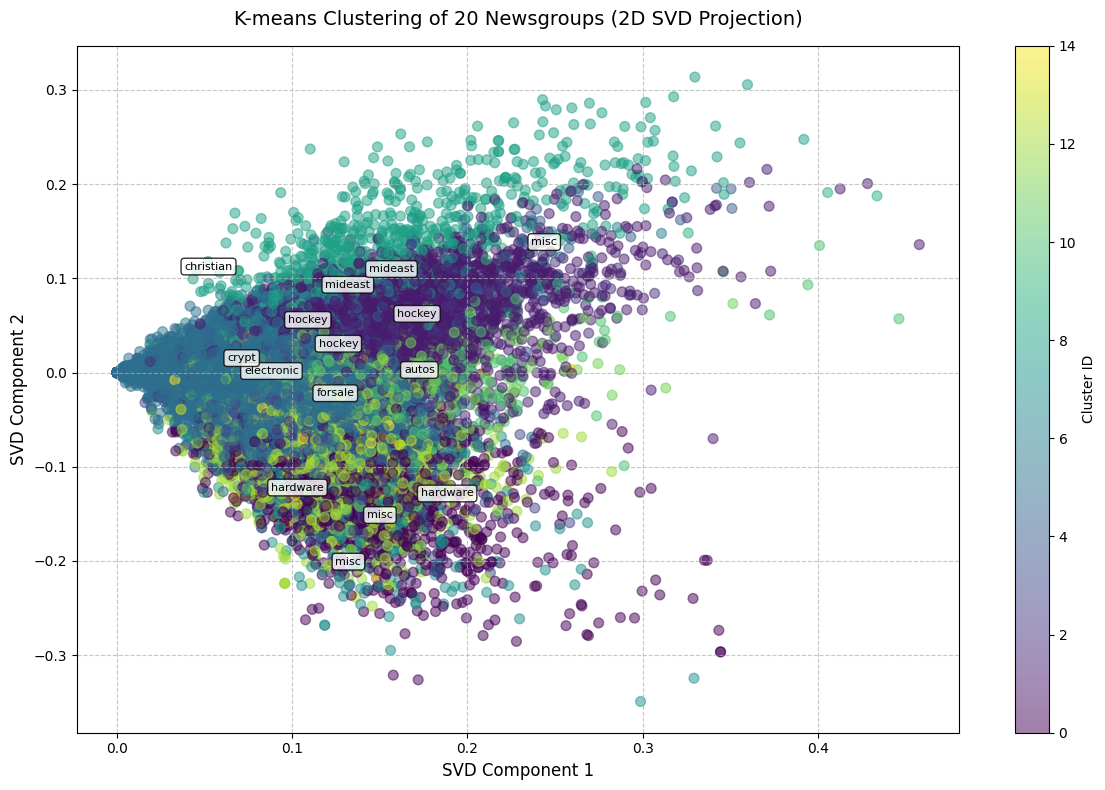

LDA Coherence Score: 0.5972
Generating LDA topic word clouds...
LDA topic 0 word cloud saved to: /content/lda_topic_0.png


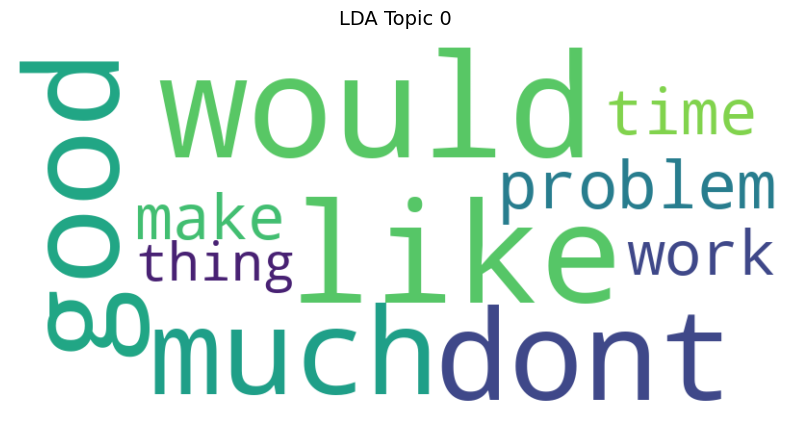

LDA topic 1 word cloud saved to: /content/lda_topic_1.png


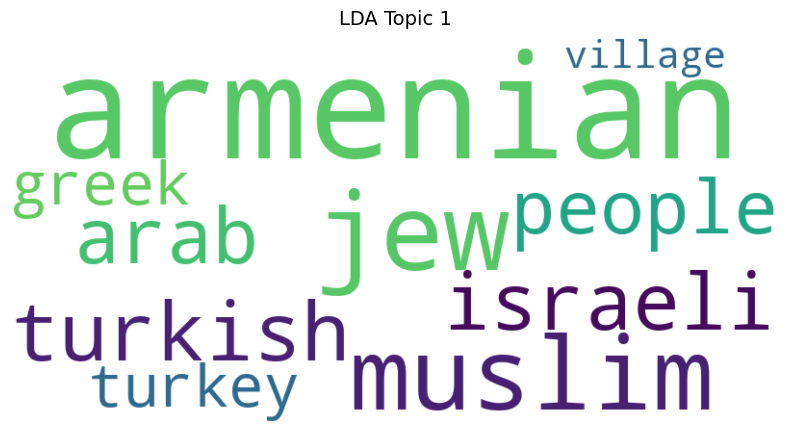

LDA topic 2 word cloud saved to: /content/lda_topic_2.png


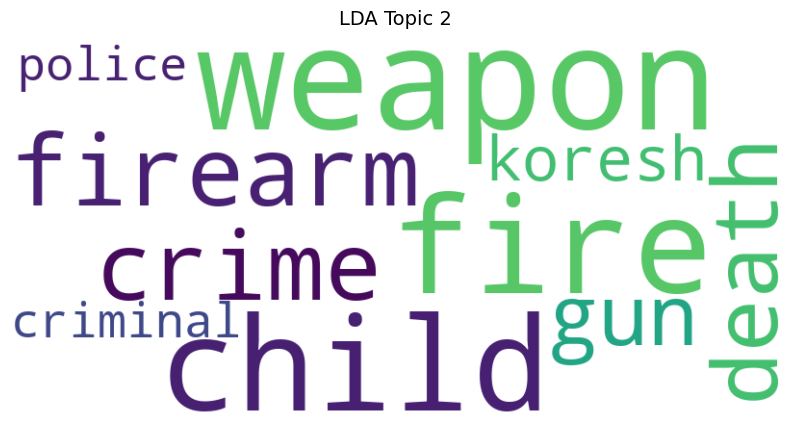

LDA topic 3 word cloud saved to: /content/lda_topic_3.png


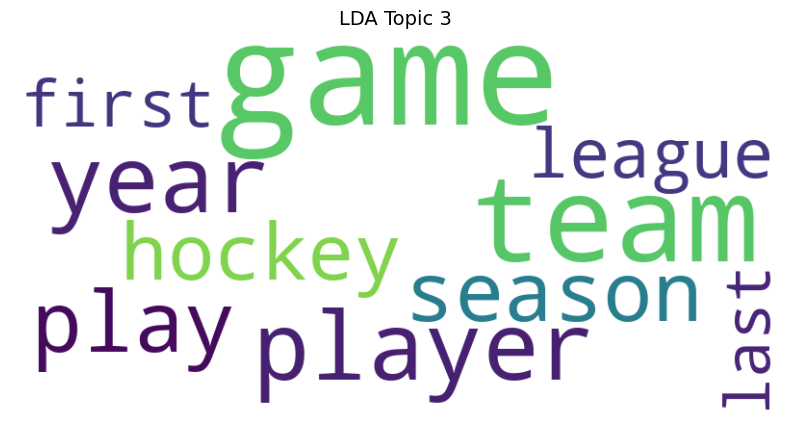

LDA topic 4 word cloud saved to: /content/lda_topic_4.png


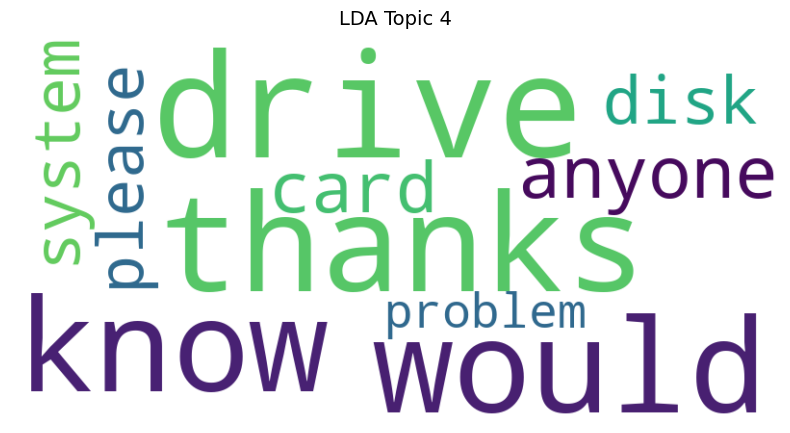

LDA topic 5 word cloud saved to: /content/lda_topic_5.png


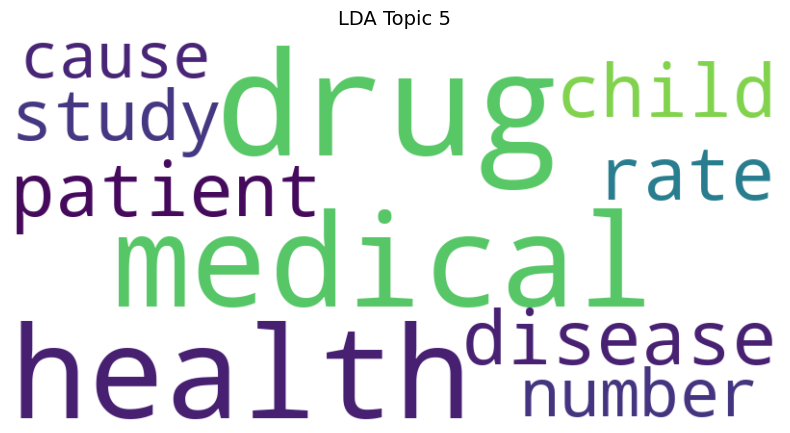

LDA topic 6 word cloud saved to: /content/lda_topic_6.png


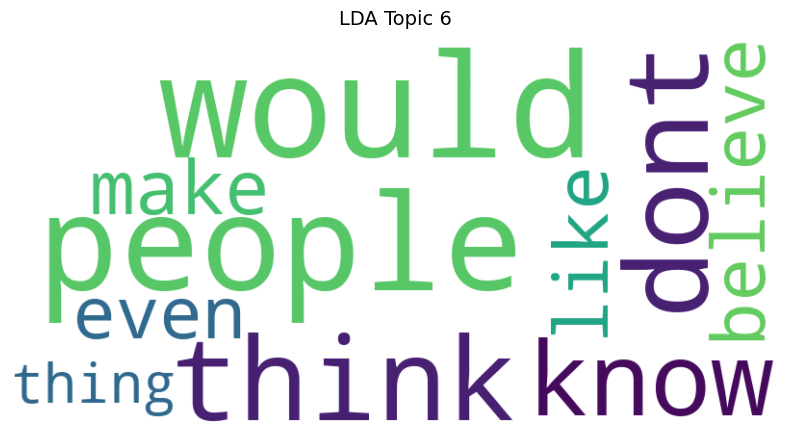

LDA topic 7 word cloud saved to: /content/lda_topic_7.png


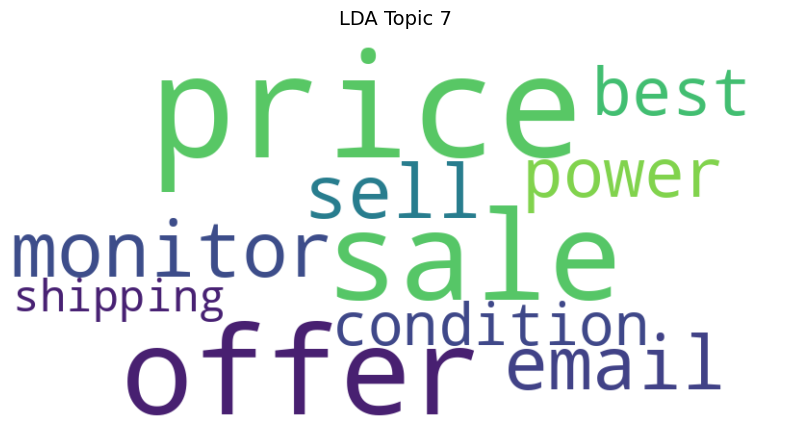

LDA topic 8 word cloud saved to: /content/lda_topic_8.png


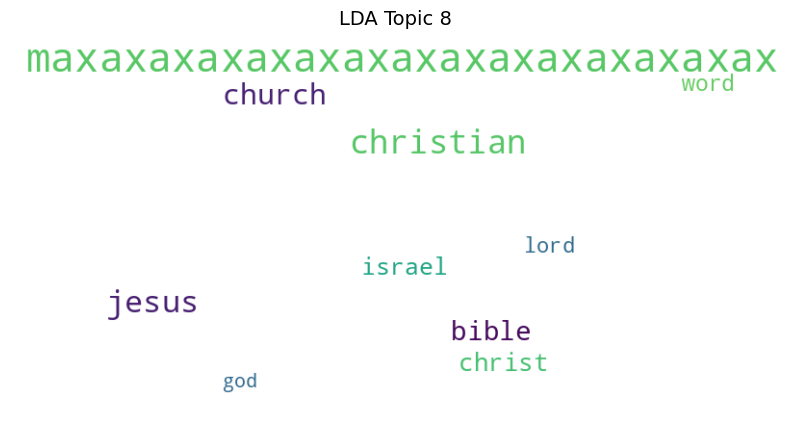

LDA topic 9 word cloud saved to: /content/lda_topic_9.png


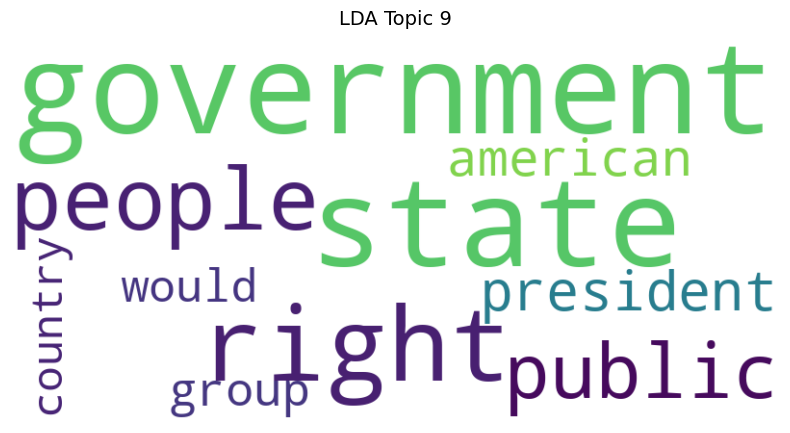

LDA topic 10 word cloud saved to: /content/lda_topic_10.png


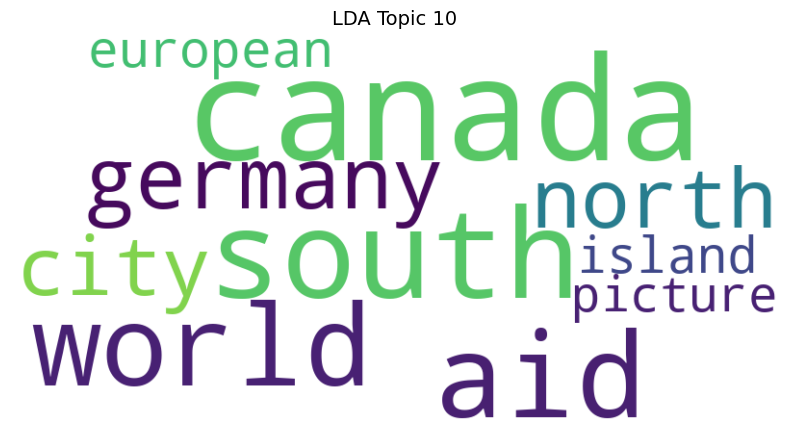

LDA topic 11 word cloud saved to: /content/lda_topic_11.png


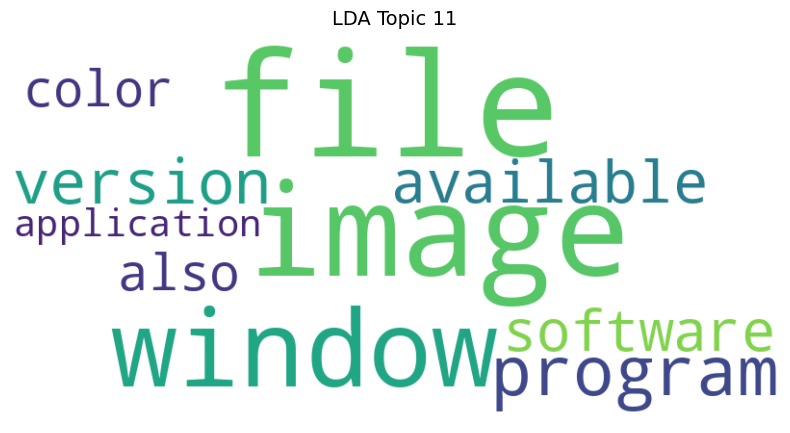

LDA topic 12 word cloud saved to: /content/lda_topic_12.png


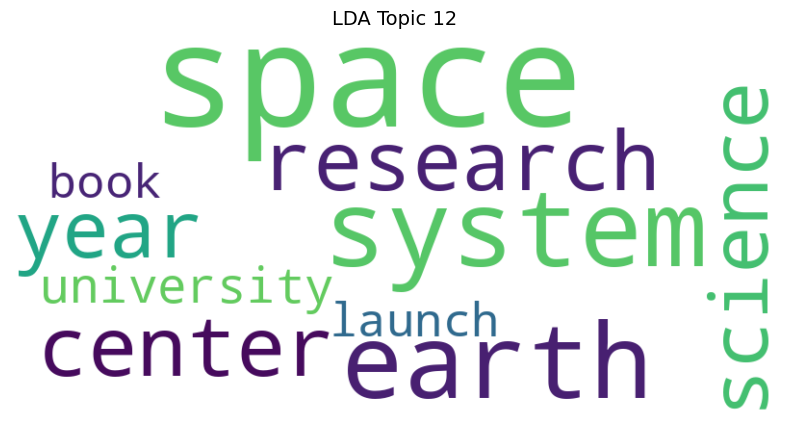

LDA topic 13 word cloud saved to: /content/lda_topic_13.png


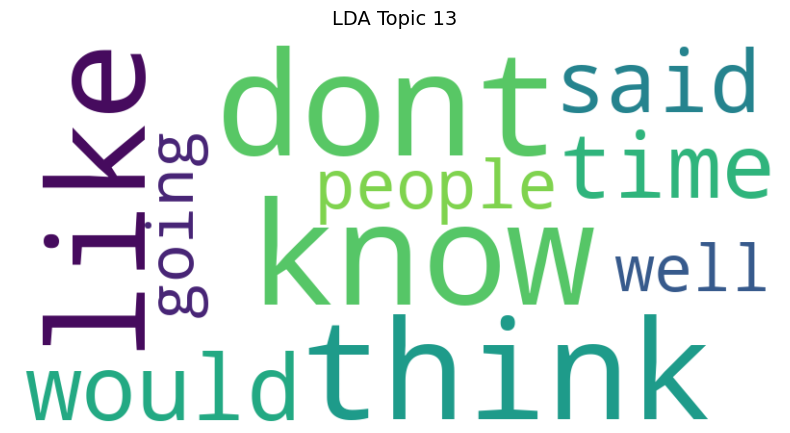

LDA topic 14 word cloud saved to: /content/lda_topic_14.png


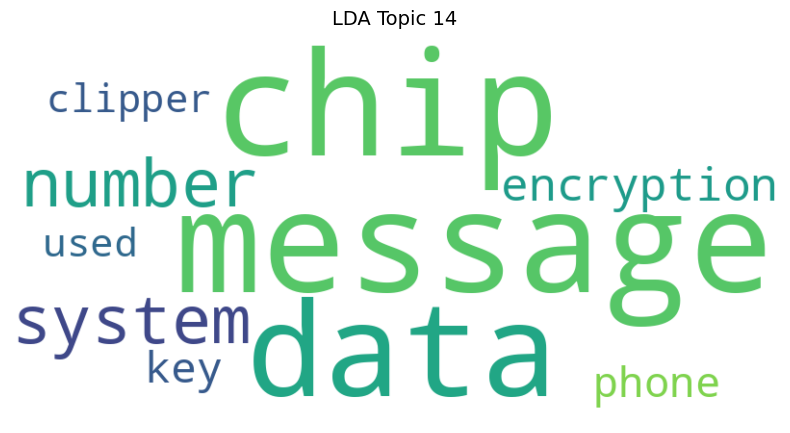


K-means Clustering Results:

Cluster 0 (Size: 1430):
Sample document from cluster 0: 1)    I have an old Jasmine drive which I cannot u...
Category: comp.sys.mac.hardware

Cluster 1 (Size: 2947):
Sample document from cluster 1: 


Yeah, it's the second one.  And I believe that ...
Category: rec.sport.hockey

Cluster 2 (Size: 1045):
Sample document from cluster 2: 

I am sure some bashers of Pens fans are pretty c...
Category: rec.sport.hockey

Cluster 3 (Size: 587):
Sample document from cluster 3: I have the following CD's that I'd like to sell:

...
Category: misc.forsale

Cluster 4 (Size: 345):
Sample document from cluster 4: 

That has not been demonstrated.  Had he come to ...
Category: talk.politics.misc

Cluster 5 (Size: 8249):
Sample document from cluster 5: 

Back in high school I worked as a lab assistant ...
Category: sci.electronics

Cluster 6 (Size: 312):
Sample document from cluster 6: Elias Davidsson writes...

ED> dear pete,
ED> 
ED>...
Category: talk.politics.mideast



In [21]:
def display_results(kmeans_clusters, lda_model, dictionary, doc_topics, documents, targets, target_names, n_top_words=10):
    print("\nK-means Clustering Results:")
    for cluster in range(max(kmeans_clusters) + 1):
        cluster_docs = [i for i, c in enumerate(kmeans_clusters) if c == cluster]
        if cluster_docs:
            print(f"\nCluster {cluster} (Size: {len(cluster_docs)}):")
            sample_doc_idx = cluster_docs[0]
            if sample_doc_idx < len(documents):
                print(f"Sample document from cluster {cluster}: {documents[sample_doc_idx][:50]}...")
                if sample_doc_idx < len(targets):
                    print(f"Category: {target_names[targets[sample_doc_idx]]}")
            else:
                print(f"Sample document from cluster {cluster}: (Unable to retrieve document)")

    print("\nLDA Topics:")
    for topic_idx, topic in lda_model.print_topics(num_words=n_top_words):
        print(f"Topic {topic_idx}:")
        print(topic)
def main():
    documents, targets, target_names = load_data()
    tokenized_docs = preprocess_text(documents)
    kmeans_clusters, X_2d, feature_names = kmeans_clustering(documents, n_clusters=15)
    visualize_clusters(X_2d, kmeans_clusters, targets, target_names)
    lda_model, dictionary, corpus, doc_topics = lda_topic_modeling(tokenized_docs, n_topics=15)
    visualize_lda_topics(lda_model)
    display_results(kmeans_clusters, lda_model, dictionary, doc_topics, documents, targets, target_names)

if __name__ == "__main__":
    main()